In [5]:
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from scipy.stats import loguniform
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix

## read data 
CIP_data_no_drop = pd.read_csv("CIP_data_encode_prev_not_dropped.csv")


In [13]:
# so what is the marginal gain? e.g. at what point is the decrease in the proprotion of people receiving effective treatment worth the decrease in unnecessary cipro? 

#So what would these look like if we just used the 5% prevalence?

##model
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 13, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )

#loop setup
threshold_seq = np.linspace(0,1,101)

#   train - from 2000 to 2010, dropped SW and Other
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])]
X_train = train_data[['MSM','MSMW', 'MSW','Northeast', 'Southeast',  'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
y_train = 1- train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)

years = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
roc_auc_by_year = []
for year in years:
     print(year)
     # test - vary by year dropped SW and Other
     test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR']== year]
     X_test = test_data[['MSM','MSMW', 'MSW', 'Northeast', 'Southeast', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
     y_test = 1 - test_data['Susceptible']
     oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
     X_test, y_test = oversample.fit_resample(X_test,y_test)

    # train model 
     model_fit_train = model_nn.fit(X_train, y_train)
     y_predict_test = model_fit_train.predict(X_test)
     y_predict_proba = model_fit_train.predict_proba(X_test)

    #get ROC_AUC (implicit 0.5 threshold)
     roc_auc = metrics.roc_auc_score(y_test, y_predict_test)
     roc_auc_by_year.append(roc_auc)


2011
2012
2013
2014
2015
2016
2017
2018


In [16]:
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR']== 2019]
X_test = test_data[['MSM','MSMW', 'MSW', 'Northeast', 'Southeast', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
y_test = test_data['Susceptible']
oversample = RandomOverSampler(sampling_strategy = 0.7,random_state=42)
X_test, y_test = oversample.fit_resample(X_test,y_test)

    # train model 
model_fit_train = model_nn.fit(X_train, y_train)
y_predict_test = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)

    #get ROC_AUC (implicit 0.5 threshold)
roc_auc = metrics.roc_auc_score(y_test, y_predict_test)
roc_auc_by_year.append(roc_auc)
years.append(2019)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.6813001266357113, 0.6847174657534247, 0.6563978707855604, 0.6324245374878286, 0.59679037111334, 0.5822932917316692, 0.5628579643510043, 0.5743090806542583, 0.5506056195179514]


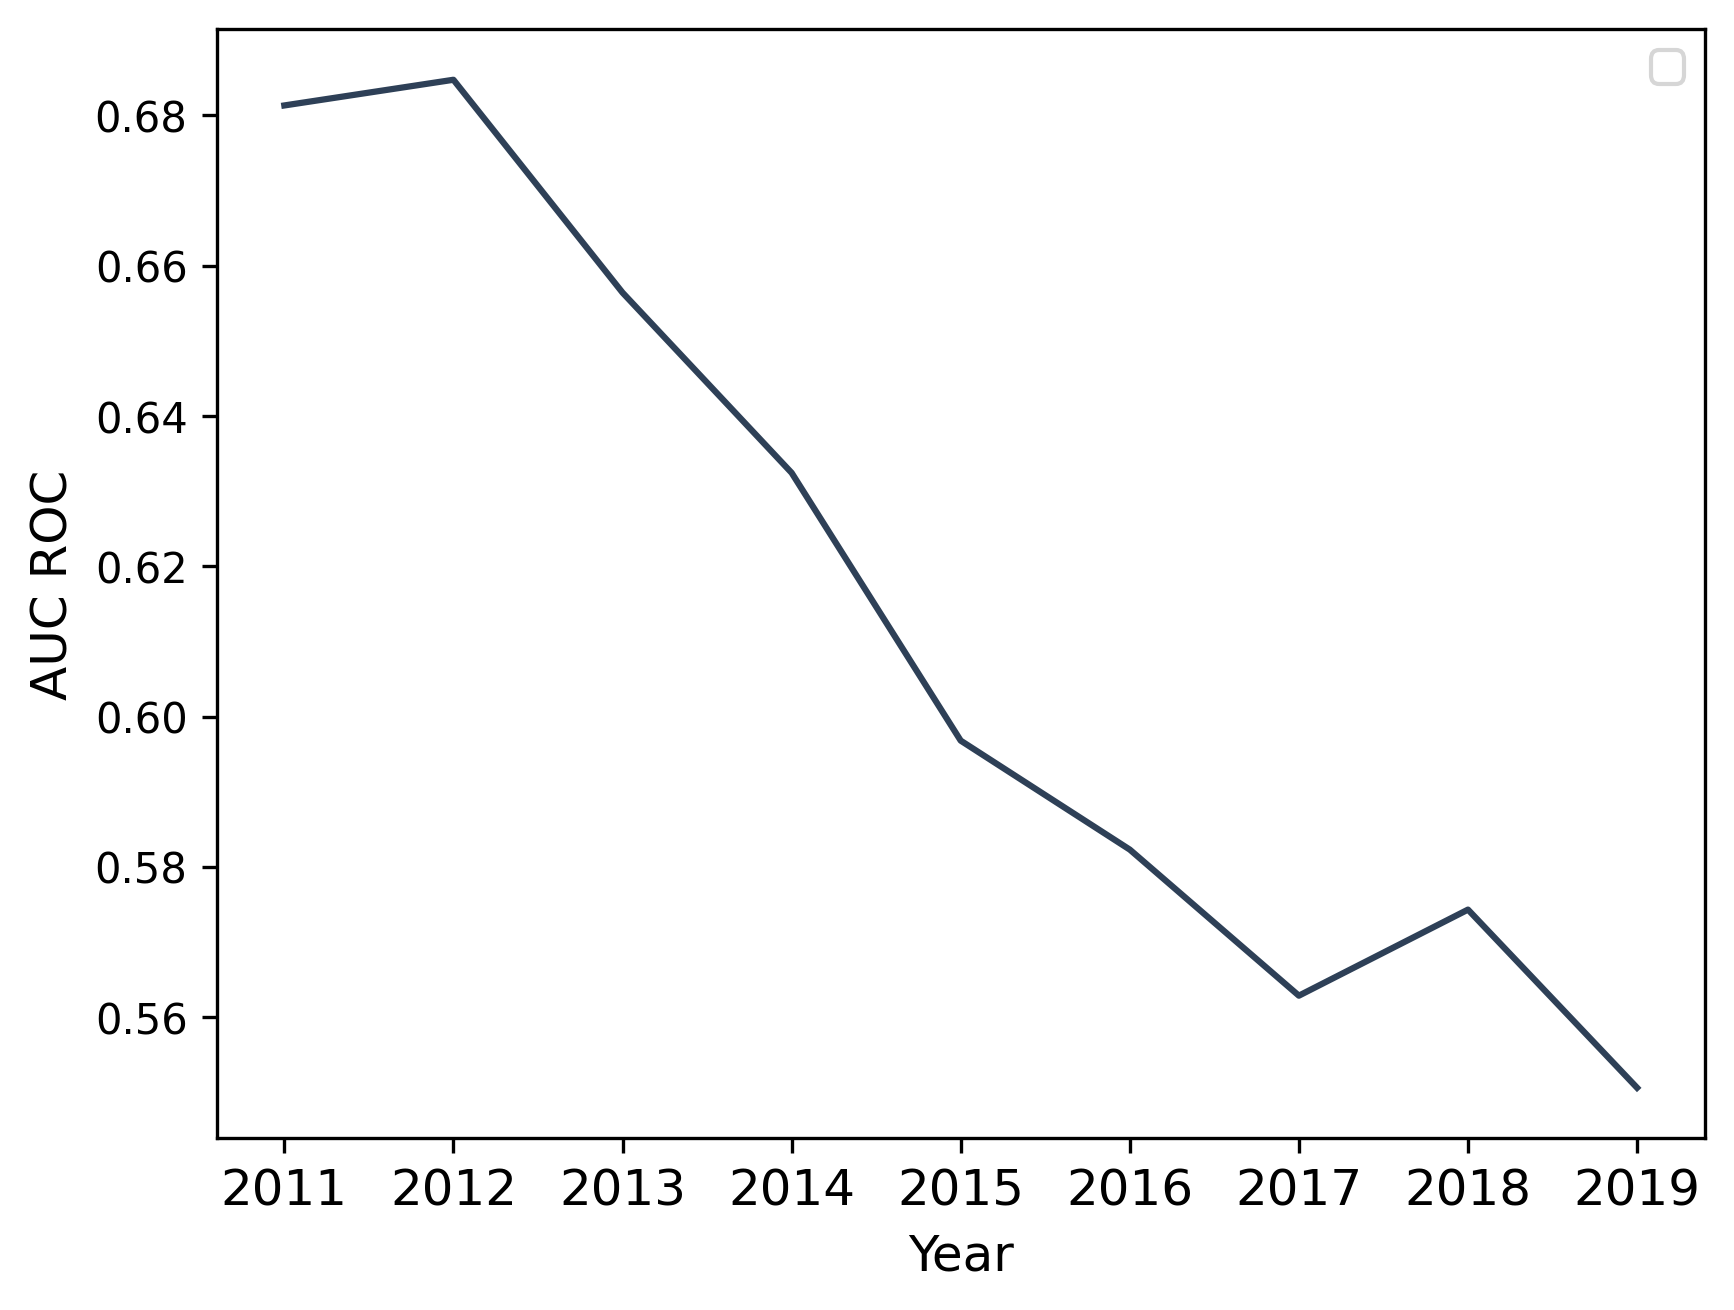

In [24]:
print(roc_auc_by_year)
plt.plot(years, roc_auc_by_year, color = "#2E4057", linestyle = 'solid')

plt.xlabel("Year", fontsize=12)
plt.ylabel("AUC ROC", fontsize=12)
plt.xticks(years, fontsize=12)
plt.rcParams['figure.dpi'] = 300
plt.legend()
plt.savefig('ROC_2000_2010_test_single_year_train_drop.png')
